In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
name="RandomForest"

In [3]:
X_train = pd.read_csv("data-train.csv",index_col=0)
Y_train = X_train.sales
X_train = X_train.drop(['sales'],axis=1)


## Hyperparameter

In [4]:
best_ccp_alpha = 0.05
best_n_est = 1000

In [5]:
np.random.seed(42)

In [6]:
Model_1 = RandomForestRegressor(ccp_alpha=best_ccp_alpha,n_estimators=best_n_est)

# 1. Get Residual Distribution

In [7]:
#Split into train and test data
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X_train,Y_train,test_size=0.2,random_state=1)

In [8]:
RG1 = Model_1
RG1.fit(X_train1,Y_train1.values.ravel())

RandomForestRegressor(ccp_alpha=0.05, n_estimators=1000)

## Out of Sample MSE

In [9]:

MSE(RG1.predict(X_test1),Y_test1)

317.8561501915478

In [10]:
result = pd.DataFrame(Y_test1)

In [11]:
result["Predicted_sales"] = RG1.predict(X_test1)

In [12]:
outSampleMSE = MSE(result["sales"],result["Predicted_sales"])
outSampleMSE

317.8561501915478

## Get Residual

In [13]:
residual = result['sales']-result['Predicted_sales']

# Get Critical factor

In [14]:
Price=20
Cost=12
Salvage=8
Over=Cost - Salvage
Under=Price - Cost
Under/(Under+Over)

0.6666666666666666

## CDF of Empirical Distribution

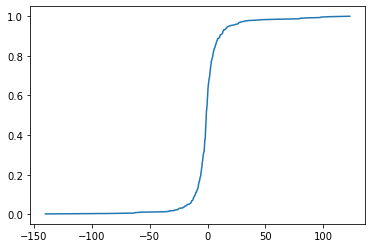

In [15]:
size = residual.shape[0]
step=1/size
jumps = [step*i for i in range(1,size+1)]
Sample = sorted(residual)
plt.plot(Sample,jumps)

## PDF of Empirical Distribution

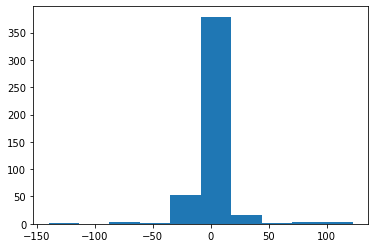

In [16]:
plt.hist(Sample)
plt.show()

In [17]:
def inv(sample,jump,area):
    size = len(sample)
    i=0
    temp=jump[i]
    while temp<area:
        i+=1
        temp=jump[i]
        
    return sample[i]

## Offset from sales to get Inventory decision

In [18]:
offset = inv(Sample,jumps,2/3)
offset

0.9929319162176284

# 2. Train Model using all available data

In [19]:
Model_f = RandomForestRegressor(ccp_alpha=best_ccp_alpha,n_estimators=best_n_est)

In [20]:
RGf = Model_f
RGf.fit(X_train,Y_train.values.ravel())

RandomForestRegressor(ccp_alpha=0.05, n_estimators=1000)

# 3. Predict sales

In [21]:
X_test = pd.read_csv("data-test.csv",index_col=0)

In [22]:
final = pd.DataFrame(RGf.predict(X_test))

In [23]:
final

,0
0,12.130364
1,3.451658
2,19.278352
3,30.081047
4,29.939526
...,...
1538,5.663369
1539,27.236247
1540,19.135085
1541,5.198280


In [24]:
#In sample MSE
MSE(RGf.predict(X_train),Y_train)

70.67672077037696

# 4. Inventory Decision

In [25]:
inventory = round(final[0]+offset)
inventory

0       13.0
1        4.0
2       20.0
3       31.0
4       31.0
        ... 
1538     7.0
1539    28.0
1540    20.0
1541     6.0
1542     5.0
Name: 0, Length: 1543, dtype: float64

## In sample MSE

In [26]:
train_pred = RGf.predict(X_train)
train_pred = pd.DataFrame(train_pred)
train_inv = round(train_pred+offset)

In [27]:
x = train_pred[0]-Y_train

In [28]:
train_table = pd.DataFrame(Y_train)

In [29]:
train_table["pred"] = train_pred

In [30]:
inSample_MSE = MSE(train_table['sales'],train_table['pred'])
inSample_MSE

70.67672077037696

## Profit Formula

In [31]:
def profit(demand,inv):
    return (Price-Salvage)*np.minimum(demand,inv)-(Cost-Salvage)*inv

In [32]:
train_profit = profit(train_table['sales'],round(train_table['pred']+offset))
train_profit.sum()

397932.0

In [33]:
train_max_profit = Y_train.sum()*(Price-Cost)
train_max_profit

449664

In [34]:
# Fraction of max profit
inSample_frac = train_profit.sum()/train_max_profit
inSample_frac

0.8849540990606319

# Do not the run code block below

insample_MSE_lst = pd.DataFrame({"In-Sample-MSE":[inSample_MSE]},index=[name])
insample_MSE_lst
m = pd.read_csv(".//Model_Prediction//In-Sample-MSE.csv",index_col=0)
m=m.append(insample_MSE_lst)
m.to_csv(".//Model_Prediction//In-Sample-MSE.csv")

insample_frac_lst = pd.DataFrame({"In-Sample-Efficiency":[inSample_frac]},index=[name])
insample_frac_lst
f = pd.read_csv(".//Model_Prediction//In-Sample-Efficiency.csv",index_col=0)
f=f.append(insample_frac_lst)
f.to_csv(".//Model_Prediction//In-Sample-Efficiency.csv")

outsample_mse_lst = pd.DataFrame({"Out-Sample-MSE":[outSampleMSE]},index=[name])
om = pd.read_csv(".//Model_Prediction//Out-Sample-MSE.csv",index_col=0)
om=om.append(outsample_mse_lst)
om.to_csv(".//Model_Prediction//Out-Sample-MSE.csv")

# Export Prediction for Test dataset

In [36]:
final_table = X_test

In [37]:
final_table["sales"]=round(final[0])

In [38]:
final_table["inventory"]=inventory

In [39]:
final_table

,productID,brandID,attribute1,attribute2,attribute3,attribute4,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,...,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales,inventory
0,0,4,3.0,90.0,2,15.410308,644.0,129.0,127.428571,7.571429,...,36.000000,0.142857,3.333333,0.666667,0.285714,2.000000,2.571429,2.833333,12.0,13.0
1,88,36,4.0,100.0,1,4.415871,198.0,249.9,135.666667,3.285714,...,40.666667,0.333333,2.500000,0.333333,0.000000,2.000000,2.000000,3.333333,3.0,4.0
2,82,11,3.0,100.0,2,9.012597,552.0,99.0,49.000000,222.285714,...,20.000000,0.000000,3.000000,0.000000,0.000000,2.000000,2.000000,3.000000,19.0,20.0
3,38,14,3.0,80.0,3,17.763691,1319.0,79.0,68.454545,18.642857,...,28.666667,0.600000,2.571429,0.533333,0.142857,2.666667,2.047619,3.000000,30.0,31.0
4,21,26,2.0,50.0,5,2.248642,851.0,69.9,55.733333,5.357143,...,32.105263,0.421053,2.894737,0.421053,0.095238,2.210526,2.761905,1.947368,30.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,43,12,3.0,60.0,1,8.618363,277.0,139.0,66.657143,13.428571,...,33.333333,0.333333,3.000000,0.600000,0.285714,2.000000,3.000000,2.166667,6.0,7.0
1539,36,19,3.0,60.0,5,2.729973,694.0,119.0,60.321951,23.071429,...,30.387097,0.225806,3.071429,0.607143,0.303030,2.214286,2.666667,2.032258,27.0,28.0
1540,24,26,2.0,50.0,2,2.342957,941.0,94.9,94.900000,14.500000,...,32.500000,0.500000,2.750000,0.500000,0.250000,2.000000,2.250000,2.250000,19.0,20.0
1541,36,19,3.0,60.0,2,23.102118,188.0,119.0,71.900000,6.714286,...,27.500000,0.125000,3.125000,0.625000,0.000000,2.375000,1.666667,2.714286,5.0,6.0


In [40]:
final_table.to_csv(f".\\Model_Prediction\\{name}.csv")